In [1]:
from pathlib import Path
import sys
import yaml
import time
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background():
    background_path = os.path.join('..', 'data', 'plot', 'background')
    city = gpd.read_file(os.path.join(background_path, "madison-meter-shp"))
    lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp"))
    street = gpd.read_file(os.path.join(background_path, "street-meter-shp"))
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

<AxesSubplot:>

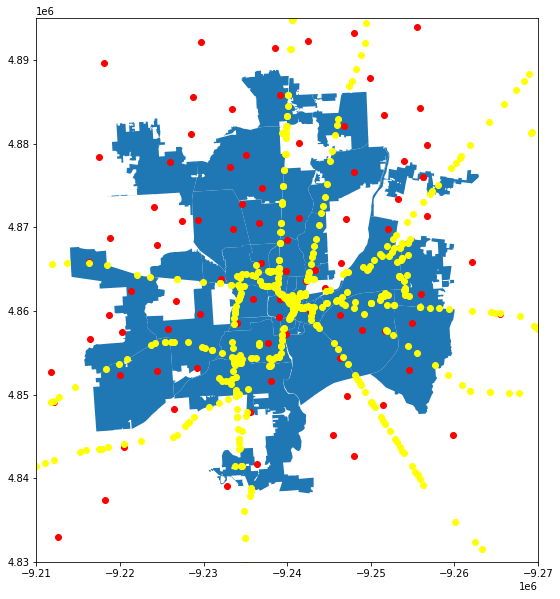

In [18]:
columb_c = gpd.read_file(os.path.join('..','data','columb','Columbus_Communities.shp'))
fire = gpd.read_file(os.path.join('..','data','columb','Central_Ohio_Fire_Stations.shp'))
transp = gpd.read_file(os.path.join('..','data','columb','Transportation_Facilities.shp'))
railroad = gpd.read_file(os.path.join('..','data','columb','Central_Ohio_Railroad_Crossings.shp'))
ax = columb_c.plot(figsize=(10,10))
ax.set_xlim([-9.21*10**6, -9.27*10**6])
ax.set_ylim([4.83*10**6, 4.895*10**6])
fire.plot(color='red', ax=ax)
# # transp.plot(color='green', ax=ax)
railroad.plot(color='yellow', ax=ax)

In [20]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'columb','columbus_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

# route remove study

In [ ]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

In [ ]:
# routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
#        23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
#        67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]

routes = [80]
for route in routes:
    print(route)
    gtfo.set_batch_label(f"{route}-rm")
    config = Config(day="monday", elapse_time="00:30:00", interval="02:00:00", max_walking_min=10, route_remove=[route])
    config.set_starts(centroids=census_gdf)

    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = gtfo.search(config, perf_df)
    gtfo.add_service_metrics(result_gdf, services_gdf, perf_df)
    gtfo.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', f'result{route}.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', f'perf{route}.csv'), index=False)

In [ ]:
result_gdf

In [ ]:
perf_df

# route doubling study

In [ ]:
print(perf_df)

In [ ]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
services_gdf = sc.load_yelp(api_key=api_key)
config = Config(day="monday", elapse_time="00:30:00", interval="10:10:00", max_walking_min=10)
config.set_starts(centroids=census_gdf)

routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
       23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
       67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]
routes = [80]

result_folder = os.path.join('.', 'out', 'result')
perf_folder = os.path.join('.', 'out', 'perf')
if not os.path.exists(result_folder): os.makedirs(result_folder)
if not os.path.exists(perf_folder): os.makedirs(perf_folder)

for route in routes:
    print(route)
    sc.gtfs_edit(edit_double, route)
    sc.set_batch_label(f"{route}-double")
    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = sc.search(config, perf_df)
    sc.add_service_metrics(result_gdf, services_gdf, perf_df)
    sc.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', 'result', f'result{route}-double.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', 'perf', f'perf{route}-double.csv'), index=False)
    break

In [ ]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
config = Config(day="monday", elapse_time="00:30:00", interval="10:00:00", max_walking_min=10)
# config.set_starts(points=[(43.073691, -89.387407), (43.073691, -89.387407)])
config.set_starts(centroids=census_gdf)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

In [ ]:
sc.gtfs_edit(edit_double, 80)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

In [ ]:
result = pd.read_csv(os.path.join('.', 'out', 'result', 'result80-double.csv'))
result["banks"].sum()

# Visualize simulation

In [ ]:
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
ax = plot_background()
gtfo.set_batch_label(f"80-rm")
example_gdf = gtfo.load_result_map(map_identifier="search-result-0-600!10")
example_gdf.plot(color="#ffbfba", ax=ax)

# AWS test

In [ ]:
from SCanalyzer.busSim.manager import managerFactory
aws = managerFactory.create("aws", gtfs_path=None, city_path=None, out_path=None)

In [ ]:
aws.clean_up()

In [ ]:
import boto3
aws_lambda = boto3.client('lambda', region_name='ap-northeast-1')
with open("tmp.zip", 'rb') as f:
    response = aws_lambda.create_function(
        Code={
            'ZipFile': f.read()
        },
        Description='BusSim handler',
        FunctionName="test",
        Handler='lambda_function.lambda_handler',
        MemorySize=512,
        Publish=True,
        Role="arn:aws:iam::347664766527:role/s3rwRole",
        Runtime='python3.8',
        Timeout=900,
        TracingConfig={
            'Mode': 'Active',
        },
    )